# Imports

In [1]:
import sys
sys.path.insert(0, "../")

from random import sample

import numpy as np
import xgboost as xgb
from matplotlib import pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

from triage.triage_torch import Triage

#### Import data and train a regressor

In [2]:
np.random.seed(0)

dataset = fetch_openml(name="house_sales", version=3)

X = dataset.data.values.astype(float)
y = dataset.target.values.astype(float)

# standardize y
y = np.array([(y[i] - y.min()) / (y.max() - y.min()) for i in range(len(y))])

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
X_prop_train, X_cal, y_prop_train, y_cal = train_test_split(
    X_train, y_train, test_size=0.25
)



/Users/nabeel/Documents/Project code/triage/new_env_triage/lib/python3.10/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


### Define a basic neural net

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

class Net1(nn.Module):
    def __init__(self, input_size=12, num_units=64, nonlin=F.relu, nlabels=1):
        super(Net1, self).__init__()

        self.dense0 = nn.Linear(input_size, num_units)
        self.dense1 = nn.Linear(num_units, 32)
        self.dense2 = nn.Linear(32, 16)
        self.dense3 = nn.Linear(16, 8)
        self.nonlin = nonlin
        self.output = nn.Linear(8, nlabels)

    def forward(self, X, **kwargs):
        X = self.nonlin(self.dense0(X))
        X = F.relu(self.dense1(X))
        X = F.relu(self.dense2(X))
        X = F.relu(self.dense3(X))
        X = self.output(X)
        return X

### Load data

In [4]:
class TrainData(torch.utils.data.Dataset):
        def __init__(self, X_data, y_data):
            self.X_data = X_data
            self.y_data = y_data

        def __getitem__(self, index):
            return self.X_data[index], self.y_data[index]

        def __len__(self):
            return len(self.X_data)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


X_train = torch.FloatTensor(X_prop_train).to(device)
y_train = torch.FloatTensor(y_prop_train).to(device)
X_cal = torch.FloatTensor(X_cal).to(device)
y_cal = torch.FloatTensor(y_cal).to(device)
X_test = torch.FloatTensor(X_test).to(device)
y_test = torch.FloatTensor(y_test).to(device)

y_eval = y_train
X_eval = X_train

###########################################
# DATALOADER
###########################################
train_data = TrainData(X_train, y_train)
trainloader = DataLoader(dataset=train_data, batch_size=128, shuffle=True)


### Setup training

In [5]:
###########################################
# MODEL SETUP
###########################################

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

n_feats = X_train.shape[1]
mlp = Net1(input_size=n_feats, nlabels=1)
mlp = mlp.to(device)

# Define the loss function and optimizer
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001)

EPOCHS=10

#### Compute TRIAGE scores

In [6]:
from tqdm import tqdm
# Define TRIAGE

try:
    triage = Triage(X_eval=X_eval, y_eval=y_eval, X_cal=X_cal, y_cal=y_cal, learner=mlp)

    # Run the training loop
    for epoch in tqdm(range(0, EPOCHS)):
        mlp.train()

        optimizer.zero_grad()

        outputs = mlp(X_train)

        loss = loss_function(outputs, y_train)
        loss.backward()
        optimizer.step()

        # EVALUATION
        mlp.eval()
        
        ###########################################
        # TRIAGE
        ###########################################
        groups_ids, raw_metrics = triage.run(learner=mlp)

except:
    import traceback
    print(traceback.format_exc())

  0%|          | 0/10 [00:00<?, ?it/s]

/Users/nabeel/Documents/Project code/triage/new_env_triage/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([8104])) that is different to the input size (torch.Size([8104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 10%|█         | 1/10 [00:01<00:09,  1.05s/it]/Users/nabeel/Documents/Project code/triage/new_env_triage/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([8104])) that is different to the input size (torch.Size([8104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 20%|██        | 2/10 [00:01<00:07,  1.01it/s]/Users/nabeel/Documents/Project code/triage/new_env_triage/lib/python3.10/site-packages/torch/nn/modules/loss.py:5

#### Get metrics & plot TRIAGE dynamics

In [7]:
score_metric = raw_metrics["score_metric"]

ue_ids = groups_ids["ue_group"] # under-estimated ids
oe_ids = groups_ids["oe_group"] # over-estimated ids
we_ids = groups_ids["we_group"] # well-estimated ids

In [8]:
# CUSTOM - can be changed based on application

percentile_thresh = 75
conf_thresh = 0.33

conf_thresh_low = conf_thresh
conf_thresh_high = 1 - conf_thresh

uncertainty = np.std(score_metric, axis=-1) 
confidence = np.mean(score_metric, axis=-1)

# over-estimated
oe_group = np.where(
(confidence <= conf_thresh_low)
& (uncertainty <= np.percentile(uncertainty, percentile_thresh))
)[0]

# under-estimated
ue_group = np.where(
(confidence >= conf_thresh_high)
& (uncertainty <= np.percentile(uncertainty, percentile_thresh))
)[0]

ue_oe_group = np.concatenate((ue_group, oe_group))

# well estimated
we_group = []
for id in range(len(confidence)):
    if id not in ue_oe_group:
        we_group.append(id)


we_group = np.array(we_group)

### Visualize the TRIAGE score's learning dynamics

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


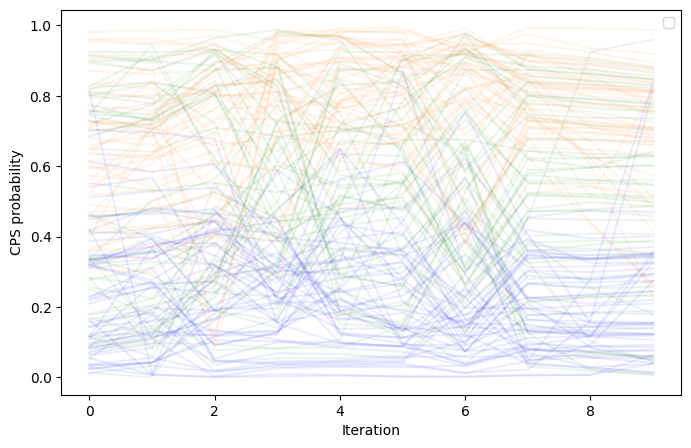

In [9]:
plt.figure(figsize=(8, 5))

alpha_val = 0.075
n = 50
e = 10
sample_ids = sample(range(len(ue_ids)), n)
for i in sample_ids:
    plt.plot(
        range(score_metric[0, :e].shape[0]),
        score_metric[ue_ids[i], :e],
        color="tab:orange",
        alpha=alpha_val,
    )

sample_ids = sample(range(len(we_ids)), n)
for i in sample_ids:
    plt.plot(
        range(score_metric[0, :e].shape[0]),
        score_metric[we_ids[i], :e],
        color="g",
        alpha=alpha_val,
    )

sample_ids = sample(range(len(oe_ids)), n)
for i in sample_ids:
    plt.plot(
        range(score_metric[0, :e].shape[0]),
        score_metric[oe_ids[i], :e],
        color="b",
        alpha=alpha_val,
    )


plt.ylabel("CPS probability")
plt.xlabel("Iteration")
plt.legend(loc=1)